(plant-reserve-strategy)=
# Plant reserve strategies

SHOP provides several ways of limiting the amount of reserve capacity that can be allocated on a single [plant](plant). This example will show how to to limit the plant production including upward/downward reserves based on the calculated TXY attributes [max_prod_all](plant:max_prod_all), [max_prod_available](plant:max_prod_available), [max_prod_spinning](plant:max_prod_spinning), and [min_prod_spinning](plant:min_prod_spinning). These attributes are calculated in every SHOP iteration, and so the resulting max/min limit constraints will change dynamically.

The three output maximum production TXYs on plant level can be used as upper limits for the sum plant production plus all upward reserve capacity by specifying the string attribute [max_prod_reserve_strategy](plant:max_prod_reserve_strategy) on plant level, or by setting the [global_settings](global_settings) string attribute [plant_max_prod_reserve_strategy](global_settings:plant_max_prod_reserve_strategy). The command [set plant_max_prod_reserve_strategy](set_plant_max_prod_reserve_strategy) can also be used to alter the attribute on global_settings. The valid strategies are "OFF", "ALL", "AVAILABLE", and "SPINNING" (upper case will be automatically applied in SHOP), and corresponds to choosing the similarly named max_prod_<> attribute as the upper limit for plant production and upward reserve capacity. Note that the default strategy on plant level is "NOT SET", which means that the strategy on global_settings will be used (default is "OFF", meaning no constraints of this type are built). Whenever the strategy on plant level is set to something other than "NOT SET", it will take precedence over the global strategy.

Similar commands and attributes are available for using min_prod_spinning as a lower limit for plant production minus downward reserve capacity. Only the "SPINNING" strategy is available for the minimum plant limit since there is only one minimum production that is calculated on the plant object. The min_prod_spinning limit is usually the same as the sum of the individual generator minimum limits since it is typically less sensitive to head dependencies, but is relevant when there is a [minimum plant production](plant:min_p_constr) or [minimum plant discharge](plant:min_q_constr) constraint active on the plant.

## Limiting the maximum production and reserve delivery on a plant

### Running a model without limits on plant reserve delivery

In [1]:
#Necessary imports used in all examples
import pandas as pd
from pyshop import ShopSession
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

#Functions used in this example for building and solving a SHOP model
from reserve import build_model, run_model

In [2]:
#For convenience, we create a function to add an RR_UP market to the basic model
def get_model_with_rr_up() -> ShopSession:
    
    #Create a new shop session
    shop=ShopSession()
    build_model(shop)

    #Add a reserve_group object for rr_up delivery and add all generators to the group
    rr_group = shop.model.reserve_group.add_object("rr_group")
    rr_group.rr_up_obligation.set(0)

    for gen in shop.model.generator:
        gen.connect_to(rr_group)

    #Add an rr_up market where rr_up can be sold for 10 €/MWh
    m = shop.model.market.add_object("rr_up_market")
    m.market_type.set("RR_UP")
    m.sale_price.set(10)
    m.max_sale.set(1000)
    m.connect_to(rr_group)
    
    return shop

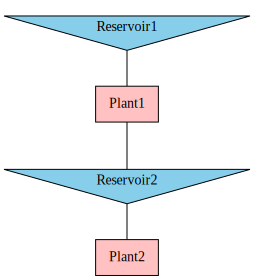

In [3]:
#Get a model with an RR_UP market
shop = get_model_with_rr_up()

#Display topology to the screen
display(shop.model.build_connection_tree())

#Optimize model
run_model(shop) 

#Save objective function value for later
obj_without_plant_max = shop.model.objective.average_objective.grand_total.get()

In [4]:
#Define a function to plot the plant production and reserve delivery including max_prod limits
def plot_plant_prod_and_up_reserve(shop:ShopSession) -> None:
    for plant in shop.model.plant:

        prod = plant.production.get()    
        rr_up = sum(gen.rr_up_delivery.get() for gen in plant.generators)

        gen_max = sum(gen.max_prod_individual.get() for gen in plant.generators)

        p_max_all = plant.max_prod_all.get()
        p_max_available = plant.max_prod_available.get()
        p_max_spinning = plant.max_prod_spinning.get()

        t = prod.index
        name = plant.get_name()

        fig = go.Figure(layout={'title':f"{name}: production and reserves",'xaxis_title':"Time",'yaxis_title':"Production and reserves [MW]"})
        fig.add_trace(go.Scatter(name="max_prod_spinning",x=t,y=p_max_spinning.values,line={'color': "blue", 'width': 2,'dash':"dash"},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="max_prod_available",x=t,y=p_max_available.values,line={'color': "red", 'width': 2,'dash':"dash"},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="max_prod_all",x=t,y=p_max_all.values,line={'color': "black", 'width': 2,'dash':"dash"},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="gen_max",x=t,y=gen_max.values,line={'color': "magenta", 'width': 2,'dash':"dash"},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="production",x=t,y=prod.values,line={'color': "black", 'width': 1},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="RR_UP",x=t, y=(prod + rr_up).values ,fill='tonexty',line={'color': "light gray", 'width': 0},line_shape='hv'))
        fig.show()

The production and RR_UP reserve capacity allocation on each plant is shown in the figures below. 

It is lucrative to sell a lot of RR_UP capacity in this SHOP run due to the relatively high reserve market price. The calculated maximum plant production considering all, available, and spinning generators are plotted in the same figures. Since there are no generators that are committed to be off in this model, max_prod_all and max_prod_available are identical, while max_prod_spinning is always lower since it only considers spinning units.

Note that the allocated RR_UP capacity is above all plant max_prod attributes in many hours. This happens because the reserve constraints are built per generator, and the maximum limit for production plus reserves are set by the calculated [max_prod_individual](generator:max_prod_individual) attribute. This maximum production limits assume that all other generators in the plant operate at their current production level, while max_prod_all on the plant is calculated assuming that all generators not on maintenance are operating at max. The sum of max_prod_individual for all generators in the plant is plotted in the figures which clearly shows that this is the constraining limit.

In [5]:
#Plot results
plot_plant_prod_and_up_reserve(shop)

### Including maximum plant reserve limits

To add stricter limits to the sum reserve delivery on each plant, the global attribute plant_max_prod_reserve_strategy is set to "ALL" while keeping the rest of the model identical:

In [6]:
#Get the same model as earlier
shop = get_model_with_rr_up()

#Specify a global max_prod reserve strategy
shop.model.global_settings.global_settings.plant_max_prod_reserve_strategy.set("ALL")

#Optimize model
run_model(shop) 

#Save objective function value for later
obj_with_plant_max = shop.model.objective.average_objective.grand_total.get()

In [7]:
#Plot the results from the new run
plot_plant_prod_and_up_reserve(shop)

Using max_prod_all as an upper limit now constrains the total production plus RR_UP delivery on each plant, and this has caused the optimal solution to change slightly. The net profit in the solution is also reduced since SHOP can't sell as much RR_UP as previously:

In [8]:
print(f"The net profit loss of using the max constraint is: {obj_with_plant_max - obj_without_plant_max:.2f} €")

The net profit loss of using the max constraint is: 14680.86 €


## Limiting the minimum production and reserve delivery on a plant

As mentioned in the introduction, minimum limits for plant production minus downward reserve capacity is usually only relevant when there is a minimum production or discharge limit on the plant. These limits are not seen by the individual generator reserve limits, but will be captured in the min_prod_spinning attribute on plant level.

### Running a model without minimum limits on plant reserve delivery

The same model as in the first example is run without any downward reserve limit on plant level, but this time RR_DOWN is sold instead of RR_UP. In addition, Plant1 and Plant2 have defined minimum production and discharge limits, respectively.

In [9]:
#Define a model with an RR_DOWN market and min_p_constr and min_q_constr on plants
def get_model_with_rr_down() -> ShopSession:
    #Create the same model as earlier
    shop=ShopSession()
    build_model(shop)

    rr_group = shop.model.reserve_group.add_object("rr_group")
    rr_group.rr_down_obligation.set(0)

    for gen in shop.model.generator:
        gen.connect_to(rr_group)

    #Add a minimum production limit on Plant1
    plant1 = shop.model.plant["Plant1"]   
    plant1.min_p_constr.set(150)

    #Add a minimum discharge limit on Plant2
    plant2 = shop.model.plant["Plant2"]   
    plant2.min_q_constr.set(300)

    m = shop.model.market.add_object("rr_down_market")
    m.market_type.set("RR_DOWN")
    m.sale_price.set(10)
    m.max_sale.set(1000)
    m.connect_to(rr_group)
    
    return shop

In [10]:
#Get a model with a RR_DOWN market and minimum production and plant limits
shop = get_model_with_rr_down()

#Optimize model
run_model(shop) 

#Save objective function value for later
obj_without_plant_min = shop.model.objective.average_objective.grand_total.get()

In [11]:
#Function to plot plant production and downward reserve capacity with min_prod limits
def plot_plant_prod_and_down_reserve(shop:ShopSession):
    for plant in shop.model.plant:

        prod = plant.production.get()    
        rr_down = sum(gen.rr_down_delivery.get() for gen in plant.generators)

        gen_min = sum(gen.min_prod_individual.get()*gen.committed_out.get() for gen in plant.generators)

        p_min_spinning = plant.min_prod_spinning.get()

        t = prod.index
        name = plant.get_name()

        fig = go.Figure(layout={'title':f"{name}: production and reserves",'xaxis_title':"Time",'yaxis_title':"Production and reserves [MW]"})
        fig.add_trace(go.Scatter(name="min_prod_spinning",x=t,y=p_min_spinning.values,line={'color': "blue", 'width': 2,'dash':"dash"},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="gen_min",x=t,y=gen_min.values,line={'color': "magenta", 'width': 2,'dash':"dash"},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="production",x=t,y=prod.values,line={'color': "black", 'width': 1},line_shape='hv'))    
        fig.add_trace(go.Scatter(name="RR_DOWN",x=t, y=(prod - rr_down).values ,fill='tonexty',line={'color': "light gray", 'width': 0},line_shape='hv'))
        fig.show()

In [12]:
#Plot the results of the base model
plot_plant_prod_and_down_reserve(shop)

It is clear from the figures above that the generators deliver RR_DOWN reserve capacity below the minimum production and discharge limits in the plant shown by the min_prod_spinning attribute. Note that the constant min_q_constr on Plant2 (300 m3/s) creates min_prod_spinning that varies with time due to the head dependency.

### Including minimum plant reserve limits

To inclue these limits, a new identical model is built with plant_min_prod_reserve_strategy set to "SPINNING":

In [13]:
#Generate the same model as before
shop = get_model_with_rr_down()

#Specify a global min_prod reserve strategy
shop.model.global_settings.global_settings.plant_min_prod_reserve_strategy.set("SPINNING")

#Optimize model
run_model(shop) 

#Save objective function value for later
obj_with_plant_min = shop.model.objective.average_objective.grand_total.get()

In [14]:
#Plot the results from the new run
plot_plant_prod_and_down_reserve(shop)

The reserve capacity allocation now respect the minimum constraints of the plant. As was the case in the first example, the net profit in SHOP has been reduced after adding the minimum reserve constraint:

In [15]:
print(f"The net profit loss of using the min constraint is: {obj_with_plant_min - obj_without_plant_min:.2f} €")

The net profit loss of using the min constraint is: 43892.96 €


## Precautions

Unlike attributes like max_p_constr which adds a constant upper limit on the plant production in every hour, the upper limits described in this example are dynamically calculated between iterations in SHOP. This means that the max_prod_<> attribute calculated in the last iteration is used as an upper limit in the next iteration. When comparing the resulting production and reserve capacity to the max_prod_<> attribute, it might appear that SHOP is violating the constraint since the max_prod_<> attribute was re-calculated *after* the optimization model has solved. This is especially true in full iterations where unit commitment is not fixed. The "SPINNING" strategy is also more prone to big changes between iterations since it depends on which units are committed on and off in each hour. Using the "ALL" and "AVAILABLE" strategies is less prone to big variations between iterations since they include offline units in the calculation. Only activating the plant reserve strategies in incremental iterations is also a possibility that will mitigate this problem.

## reserve_cap.py

In [16]:
with open('reserve.py', 'r') as f:
    print(f.read())

import pandas as pd
import numpy as np

def build_model(shop):
    starttime = pd.Timestamp('2018-01-23 00:00:00')
    endtime = pd.Timestamp('2018-01-26')
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour", timeresolution=pd.Series(index=[starttime],data=[1]))
    
    rsv1 = shop.model.reservoir.add_object('Reservoir1')
    rsv1.max_vol.set(39)
    rsv1.lrl.set(860)
    rsv1.hrl.set(905)
    rsv1.vol_head.set(pd.Series([860, 906, 907], index=[0, 39, 41.66], name=0))    

    rsv2 = shop.model.reservoir.add_object('Reservoir2')
    rsv2.max_vol.set(97.5)   
    rsv2.lrl.set(650)   
    rsv2.hrl.set(679)    
    rsv2.vol_head.set(pd.Series([650, 679, 680], index=[0, 97.5, 104.15], name=0))
    
    plant1 = shop.model.plant.add_object('Plant1')
    plant1.outlet_line.set(672)
    plant1.main_loss.set([0])
    plant1.penstock_loss.set([0.001])
    plant1.mip_flag.set(1)
    for gen_no in range(2):
        gen=shop.model.generator.add_object(f"{plant1.get_